Transfer Learning, ResNet50
Phan biet cac loai te bao mau (Eosinophil, Lymphocyte, Monocyte, and Neutrophil). Nham muc dich ho tro vao linh vuc y hoc khi can xet nghiem 1 so luong lon mau mau.

### Import libraries

In [2]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [27]:
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, ZeroPadding2D, MaxPooling2D, Activation, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [4]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
from PIL import Image
from skimage import transform
from tqdm import tqdm
import cv2
from glob import glob

### Load the data

In [28]:
train_path = 'Dataset/dataset2-master/dataset2-master/images/TRAIN'
validation_path = 'Dataset/dataset2-master/dataset2-master/images/TEST'

In [29]:
train_image_files = glob(train_path + "/*/*.jp*g")
validation_image_files = glob(validation_path + "/*/*.jp*g")
print(f"Number of Training samples: {len(train_image_files)}")
print(f"Number of Validation samples: {len(validation_image_files)}")

Number of Training samples: 9957
Number of Validation samples: 2487


In [30]:
folders = glob(train_path + '/*')
k = len(folders)
print(f"Number of clases: {k}")

Number of clases: 4


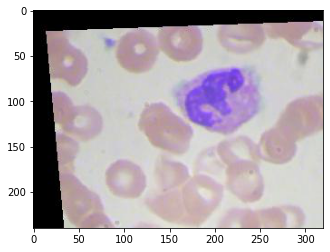

In [31]:
# Show random image
plt.imshow(image.img_to_array(image.load_img(train_image_files[0])).astype('uint8'))
plt.show()

### Load ResNet50 model

In [32]:
IMAGE_SIZE = [200, 200]
EPOCHS = 5
BATCH_SIZE = 32
# Do em lien tuc bi crash RAM khi chay model, nen set cac thong so nho lai

In [33]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 0s 0us/step


In [34]:
for layer in resnet.layers:
    layer.trianable = False

In [35]:
x = Flatten()(resnet.output)
pred = Dense(k, activation='softmax')(x)

In [36]:
model = Model(inputs = resnet.inputs, outputs = pred)

In [37]:
model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [38]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [39]:
data_gen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             preprocessing_function=preprocess_input)

In [40]:
test_gen = data_gen.flow_from_directory(validation_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


In [41]:
# Extract the labels 
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
      labels[v] = k

In [42]:
train_generator = data_gen.flow_from_directory(train_path,
                                              target_size=IMAGE_SIZE,
                                              shuffle=True,
                                              batch_size=BATCH_SIZE)

validation_generator = data_gen.flow_from_directory(validation_path,
                                             target_size=IMAGE_SIZE,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [43]:
spe = int(len(train_image_files)//BATCH_SIZE)
val = int(len(validation_image_files)//BATCH_SIZE)
print(f"Training steps per epoch: {spe}")
print(f"Validation steps per epoch: {val}")
print(f"Number of epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")

Training steps per epoch: 311
Validation steps per epoch: 77
Number of epochs: 5
Batch size: 32


In [44]:
es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   min_delta=1, 
                   patience=50,
                   verbose=1,
                   restore_best_weights=True
                   )

In [45]:
mc = ModelCheckpoint('/content/drive/MyDrive/LDS8_K279_ONLINE_Nguyen_Minh_Hung/LDS8_K279_NguyenMinhHung_Cuoi_ky/Dataset/best_model_ResNet50_cau4.h5', 
                     monitor='val_accuracy', 
                     mode='max',
                     verbose=1,
                     save_best_only=True,
                     )

In [46]:
from keras import callbacks
res = model.fit_generator(train_generator,
                          validation_data=validation_generator,
                          epochs=EPOCHS,
                          steps_per_epoch=spe,
                          validation_steps= val,
                          callbacks=[es, mc],
                          verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
311/311 [==============================] - ETA: 0s - loss: 2.9701 - accuracy: 0.4023
Epoch 1: val_accuracy improved from -inf to 0.23661, saving model to /content/drive/MyDrive/LDS8_K279_ONLINE_Nguyen_Minh_Hung/LDS8_K279_NguyenMinhHung_Cuoi_ky/Dataset/best_model_ResNet50_cau4.h5
311/311 [==============================] - 186s 535ms/step - loss: 2.9701 - accuracy: 0.4023 - val_loss: 11.3499 - val_accuracy: 0.2366
Epoch 2/5
311/311 [==============================] - ETA: 0s - loss: 1.1056 - accuracy: 0.6399
Epoch 2: val_accuracy improved from 0.23661 to 0.53450, saving model to /content/drive/MyDrive/LDS8_K279_ONLINE_Nguyen_Minh_Hung/LDS8_K279_NguyenMinhHung_Cuoi_ky/Dataset/best_model_ResNet50_cau4.h5
311/311 [==============================] - 163s 524ms/step - loss: 1.1056 - accuracy: 0.6399 - val_loss: 1.8960 - val_accuracy: 0.5345
Epoch 3/5
311/311 [==============================] - ETA: 0s - loss: 0.7648 - accuracy: 0.7998
Epoch 3: val_accuracy did not improve from 0.53450


### Evaluate

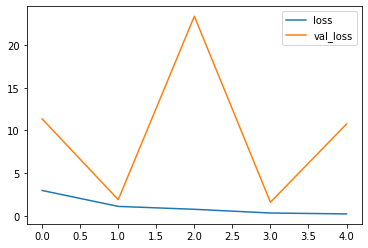

In [51]:
plt.plot(res.history['loss'], label='loss')
plt.plot(res.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

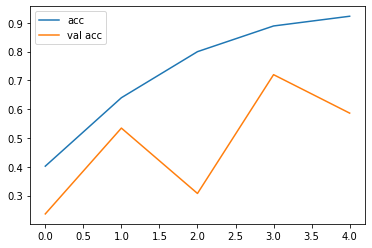

In [52]:
# accuracies
plt.plot(res.history['accuracy'], label='acc')
plt.plot(res.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

Nhan xet: model chua thuc su tot.
So voi cau 3 thi su dung Transfer Learning (ResNet50) co thoi gian train model nhanh hon. Nhung do chinh xac lai thap hon cau 3.